In [1]:
import torch

In [2]:
class GAN(torch.nn.Module):
    
    def __init__(self, convtrans_channel=[6,3,1], conv_channel=[1,3,6,1],z_dim=64,channel_input=1,bs=128,device='cuda'):
        
        super(type(self), self).__init__()
        self.z_dim=z_dim
        self.batch=bs
        self.channel=channel_input
        self.device=device
        
        ##capas generadoras
        self.generative_layers = torch.nn.Sequential(
                                  torch.nn.ConvTranspose2d(self.channel,convtrans_channel[0],4,stride=2,padding=2 ),
                                  torch.nn.BatchNorm2d(convtrans_channel[0]),
                                  torch.nn.ReLU(),
                                  torch.nn.ConvTranspose2d(convtrans_channel[0],convtrans_channel[1],5,padding=4),
                                  torch.nn.BatchNorm2d(convtrans_channel[1]),
                                  torch.nn.ReLU(),
                                  torch.nn.ConvTranspose2d(convtrans_channel[1],convtrans_channel[2],3,stride=2),
                                  torch.nn.Tanh(),
                                  
            
                                )
        self.discriminator_layers= torch.nn.Sequential(
                                   torch.nn.Conv2d(conv_channel[0],conv_channel[1],5,stride=2,padding=1),
                                   torch.nn.LeakyReLU(),
                                   torch.nn.Conv2d(conv_channel[1],conv_channel[2],5,stride=3,padding=1),
                                   torch.nn.BatchNorm2d(conv_channel[2]),
                                   torch.nn.LeakyReLU(),
                                   torch.nn.Conv2d(conv_channel[2],conv_channel[3],5,stride=2,padding=1),
                                   torch.nn.Sigmoid(),                                
        
                                )
        
        
       # self.activation=torch.nn.ReLU()
        
    
    def generador(self, z):
        z=z.view(-1,self.channel,8,8)
        x_falso=self.generative_layers(z)
        return x_falso
        
    def discriminador(self,supuesto_x):
        supuesto_x=self.discriminator_layers(supuesto_x)
        supuesto_x=supuesto_x.view(-1,1)
        return supuesto_x
    
    def sample(self,size):
        z=torch.randn(size,self.channel*self.z_dim , device=self.device)
        return z
    def loss_disc(self,x):
        x_falso=self.generador(self.sample(x.shape[0]))
        disc_datos_x= self.discriminador(x)
        disc_datos_xfalso= self.discriminador(x_falso)
        loss=(torch.log(disc_datos_x) + torch.log(1 - disc_datos_xfalso) ).sum() / self.batch
        return -loss
    
    def loss_gen(self,size):
        x_falso=self.generador(self.sample(size))
        disc_datos_xfalso=self.discriminador(x_falso)
        loss=torch.log(disc_datos_xfalso).sum() / self.batch
        return -loss
        
    def forward(self,z):
        x_falso=self.generador(z)
        return x_falso
       
def freeze_gen(model):
    count=0
    for parameter in model.parameters():
        if count<10:
            parameter.requires_grad=False
        else:
            parameter.requires_grad=True
        count+=1 
    return model
    
def freeze_disc(model):
    count=0
    for parameter in model.parameters():
        if count<10:
            parameter.requires_grad=True
        else:
            parameter.requires_grad=False
        count+=1 
    return model



In [3]:
ls /opt/data-nas/HiTS

images_test.csv*  images_train.csv*  label_test.csv*  label_train.csv*


### cargamos el CSV de entrenamiento

In [4]:
import pandas as pd
import numpy as np
df=pd.read_csv("/opt/data-nas/HiTS/images_train.csv",header=None)
differences=np.array(df.iloc[:,0:21*21])
df=0  ##manera trucha de liberar memoria by javier rojas
df=pd.read_csv("/opt/data-nas/HiTS/label_train.csv",header=None)
labels=np.array(df)
df=0

### creamos dataloader

In [5]:
from torch.utils.data import TensorDataset, DataLoader, Subset 
batch_size=128
astro_image_tensor=torch.from_numpy(differences.astype('float32')).view(-1,1,21,21)
im_min = astro_image_tensor.min(dim=-1).values.min(dim=-1).values.reshape(-1, 1, 1, 1)
im_max = astro_image_tensor.max(dim=-1).values.max(dim=-1).values.reshape(-1, 1, 1, 1)
astro_image_tensor = (astro_image_tensor - im_min)/(im_max-im_min)

astro_dataset = TensorDataset(astro_image_tensor, torch.from_numpy(labels))

train_loader = DataLoader(astro_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

## Entrenamiento

In [10]:
from tqdm import tqdm_notebook
n_epoch=500
k_disc=1
model=GAN(bs=batch_size)
model=model.cuda()
den = train_loader.__len__()*train_loader.batch_size
#den_val = valid_loader.__len__()*valid_loader.batch_size
global_loss=np.inf
for epoch in tqdm_notebook(range(n_epoch)):
    train_disc_loss=0.0
    ##congelar capas del generador
    model=freeze_gen(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for k in range(k_disc):
        for image,label in train_loader:
            optimizer.zero_grad()  
            image=image.cuda()
            loss=model.loss_disc(image)
            loss.backward()
            optimizer.step()
            train_disc_loss += loss.item()
    print("Train loss discriminador: ",train_disc_loss)
    ##descongelar capas generador y congelar las de discriminador 
    model=freeze_disc(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_gen_loss=0.0
    for image,label in train_loader:
        optimizer.zero_grad()  
        image=image.cuda()
        loss=model.loss_gen(image.shape[0])
        loss.backward()
        optimizer.step()
        train_gen_loss += loss.item()
    print("Train loss generador: ",train_gen_loss)


/home/admin/miniconda3/envs/PT/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Train loss discriminador:  72.3067051102189
Train loss generador:  188.6499634800748
Train loss discriminador:  102.78093724380597
Train loss generador:  45.42098226145208
Train loss discriminador:  110.53855947939883
Train loss generador:  80.24094166222312
Train loss discriminador:  125.31940546550322
Train loss generador:  122.69738350524676
Train loss discriminador:  132.37289593211608
Train loss generador:  59.641723435459426
Train loss discriminador:  123.01912416282721



KeyboardInterrupt: 

In [87]:
model=GAN(device='cpu')


In [60]:
filter(lambda p: p.requires_grad, model.parameters())

In [93]:
model=freeze_gen(model)

In [94]:
for parameter in model.parameters():
    print(parameter.requires_grad)

False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True


In [52]:
x=model.sample(1)

In [53]:
x=model.forward(x)

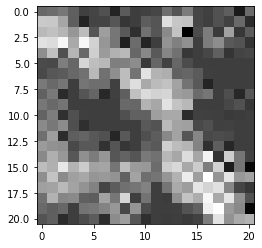

In [54]:
import matplotlib.pyplot as plt
x=x.cpu()
plt.imshow(x[0][0].detach().numpy(),cmap="gray")